## Table of Content:
* [Data Preparation & Visualisation](#data-prep-viz)
* [Machine Learning](#ml)

In [1]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from skimpy import skim
import math

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Preparation & Visualisation <a class="anchor" id="data-prep-viz"></a>

## Helper Functions

In [3]:
NUMPY_INTS = [np.dtypes.Float64DType, np.dtypes.Float32DType, np.dtypes.Int64DType, np.dtypes.Int32DType]

def fetch_data(url, out_file):
  res = requests.get(url)
  if res.content:
    with open(out_file, "w") as csv_file:
      writer = csv.writer(csv_file)
      content = res.content.decode("utf-8").split("\n")
      for line in content:
        line = [entry.replace('"', '').replace('\r', '') for entry in line.split(",")]
        writer.writerow(line)

# Returns a cleaned up dataframe
def do_basic_cleanup(df, drop_cols):
    try:
      df = df.drop(columns=drop_cols)
    except Exception as e:
      print(e)
    df = df.rename(columns={c: c.lower().replace(" ", "_").replace("(", "").replace(")", "") for c in df.columns})
    return df

# returns a series with Value counts, where ....
# https://www.kaggle.com/code/parulpandey/five-ways-to-use-value-counts
def value_counts(df):
    res = []
    for col in df.columns:
      preliminary_res = df[col].value_counts()
      if preliminary_res.size > 20:
        if type(df[col].dtype) in NUMPY_INTS:
          preliminary_res = df[col].value_counts(bins=10)
          preliminary_res.name = preliminary_res.name + "- BINNED"
        else:
          preliminary_res = df[col].value_counts(normalize=True)  
          preliminary_res.name = preliminary_res.name + "- NORMALIZED"
      res.append(preliminary_res)
    return res


In [213]:
# Source: https://data.cso.ie/table/ASA02
fetch_data("https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/ASA02/CSV/1.0/en", "irl_tourism.csv")

In [4]:
df = pd.read_csv("irl_tourism.csv", on_bad_lines='warn')
df.head(10)

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02293V02763,Direction,C03042V03675,Route,UNIT,VALUE
0,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,-,All routes of travel,Thousand,12902.2
1,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,01,Cross channel,Thousand,6113.0
2,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,02,Continental Europe,Thousand,5652.6
3,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,03,Transatlantic,Thousand,914.5
4,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,04,Other,Thousand,222.1
5,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,-,All routes of travel,Thousand,12920.2
6,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,01,Cross channel,Thousand,6132.4
7,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,02,Continental Europe,Thousand,5643.3
8,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,03,Transatlantic,Thousand,924.3
9,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,04,Other,Thousand,220.3


In [5]:
df = do_basic_cleanup(df, ["STATISTIC", "STATISTIC Label", "TLIST(A1)", "C02293V02763", "C03042V03675", "UNIT"])

df = df.dropna()
df = df.astype({"year": int})
df.head()

,year,direction,route,value
0,2010,Arrivals,All routes of travel,12902.2
1,2010,Arrivals,Cross channel,6113.0
2,2010,Arrivals,Continental Europe,5652.6
3,2010,Arrivals,Transatlantic,914.5
4,2010,Arrivals,Other,222.1


In [6]:
#df.apply(lambda col: col.value_counts(), axis=1)
#skim(df)
df['value'].value_counts(bins=7)
print(type(df['value'].dtype))

(128.722, 3074.486]       64
(5999.771, 8925.057]      33
(3074.486, 5999.771]      12
(11850.343, 14775.629]    10
(17700.914, 20626.2]       8
(8925.057, 11850.343]      7
(14775.629, 17700.914]     6
Name: count, dtype: int64

<class 'numpy.dtypes.Float64DType'>


## Looking at arrivals from different destinations 

In [7]:
arrivals = df[(df['direction'] == 'Arrivals') & (df['route'] != 'All routes of travel')]
departures = df[(df['direction'] == 'Departures') & (df['route'] != 'All routes of travel')]

In [8]:
arrivals.head()

,year,direction,route,value
1,2010,Arrivals,Cross channel,6113.0
2,2010,Arrivals,Continental Europe,5652.6
3,2010,Arrivals,Transatlantic,914.5
4,2010,Arrivals,Other,222.1
11,2011,Arrivals,Cross channel,6102.5


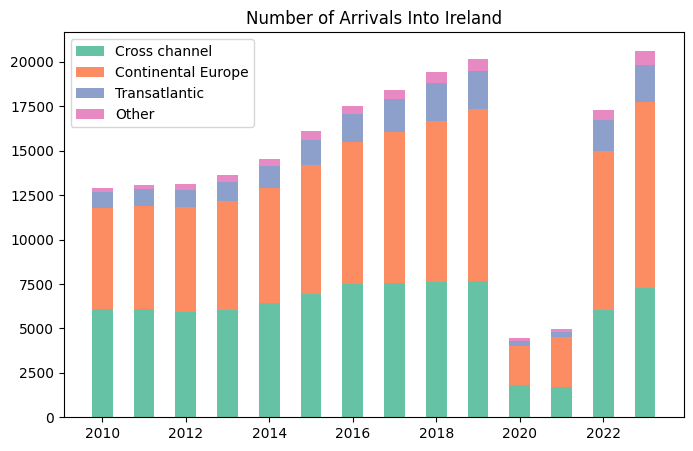

In [10]:
#sns.set_theme(style="whitegrid")

#ax = sns.barplot(data=arrivals, x="year", y="value", hue="route", palette='flare')

x = arrivals['year'].unique()
routes = arrivals['route'].unique()
bottom = np.zeros(len(x))
palette = sns.color_palette("Set2")

_, ax= plt.subplots(figsize=(8, 5))
width = 0.5

#for year in x:
for i, route in enumerate(routes):
   data = arrivals[arrivals['route'] == route]['value']
   _ = ax.bar(x, data, width, label=route, bottom=bottom, color=palette[i])
   bottom += data.to_numpy()

_ = ax.set_title("Number of Arrivals Into Ireland")
_ = ax.legend(loc="upper left")


## Explore percent change Year over Year

In [11]:
arrivals_cols = arrivals.set_index(['year', 'route'])['value'].unstack()
raw_cols = arrivals_cols.columns
new_cols = []
for c in arrivals_cols.columns.to_numpy():
    new_col = "ptc_ch_" + c.lower().replace(" ", "_")
    new_cols.append(new_col)
    arrivals_cols[new_col] = round(arrivals_cols[c].pct_change() * 100, 2)
arrivals_cols = arrivals_cols.drop(columns=raw_cols)
arrivals_cols = arrivals_cols.reset_index()
arrivals_cols.head()

route,year,ptc_ch_continental_europe,ptc_ch_cross_channel,ptc_ch_other,ptc_ch_transatlantic
0,2010,NaN,NaN,NaN,NaN
1,2011,2.30,-0.17,4.55,1.97
2,2012,2.38,-2.82,43.84,2.68
3,2013,3.72,1.44,14.85,14.16
4,2014,5.09,6.75,12.96,13.31


## Flights to Ireland from other international airports
1. Data from https://ec.europa.eu/eurostat/web/transport/data/database
2. https://ec.europa.eu/eurostat/databrowser/explore/all/transp?lang=en&subtheme=avia.avia_pa.avia_par&display=list&sort=category&extractionId=avia_par_ie
3. Explanatory notes on the data https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en
4. API https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/ESTAT/avia_par_ie$defaultview/1.0?references=descendants&detail=referencepartial&format=sdmx_2.1_generic&compressed=true

|Dimension	| Agency : Code list | Values |
| --- | --- | --- |
|FREQ | Time frequency	ESTAT : FREQ | Annual, Quarterly, Monthly ||
|UNIT | Unit of measure	ESTAT : UNIT | Passenger, Flights, Seats and berths||
|TRA_MEAS | Traffic and transport measurement	ESTAT : TRA_MEAS ||
|AIRP_PR | Airport pairs (routes)	ESTAT : AIRP_PR ||
|OBS_FLAG | Observation status (Flag)	ESTAT : OBS_FLAG ||

In [226]:
#IRL_AIRPORT_PASS_TRAVEL = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/ESTAT/avia_par_ie$defaultview/1.0?references=descendants&detail=referencepartial&format=sdmx_2.1_generic&compressed=true"
# https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/avia_par_ie/?format=SDMX-CSV&lang=en&label=both
# https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/avia_par_ie/?format=TSV
# https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en&category=avia.avia_pa.avia_par

# https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en&category=avia.avia_pa.avia_par

### ONLY REPLAY IF DATASET IS MISSING< IT IS VERY BIG
fetch_data("https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/avia_par_ie/1.0?compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name", 
           "flights.csv")

In [12]:
# Cannot commit the dataset to GitHub, as it is beyond the file size allowd by GH
# Replay the previous step to generate the dataset
# low_memory=False due to mixed datatypes
flights = pd.read_csv("flights.csv", low_memory=False)

In [13]:
#pd.set_option('display.max_columns', 100)
#pd.set_option('display.width', 1000)
#flights.columns
flights.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,unit,Unit of measure,tra_meas,Traffic and transport measurement,airp_pr,Airport pairs (routes),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag)
0,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,2012,NaN,256.0,NaN,NaN,NaN
1,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,2013,NaN,248.0,NaN,NaN,NaN
2,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CH_LSZH,CORK airport - ZURICH airport,2019,NaN,213.0,NaN,NaN,NaN
3,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CZ_LKPR,CORK airport - PRAHA/RUZYNE airport,2003,NaN,296.0,NaN,NaN,NaN
4,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CZ_LKPR,CORK airport - PRAHA/RUZYNE airport,2004,NaN,557.0,NaN,NaN,NaN


In [14]:
# Remove column repetitions
flights = do_basic_cleanup(flights, ["STRUCTURE", "STRUCTURE_ID", "STRUCTURE_NAME", 
                                     "freq", 'unit', 'Time', 'Observation value', 'Observation status (Flag)', 'OBS_FLAG', 'tra_meas', 'Airport pairs (routes)'])

In [15]:
flights.dtypes
flights.value_counts()

time_frequency                        object
unit_of_measure                       object
traffic_and_transport_measurement     object
airp_pr                               object
time_period                           object
obs_value                            float64
dtype: object

time_frequency  unit_of_measure   traffic_and_transport_measurement        airp_pr          time_period  obs_value
Annual          Flight            Commercial passenger air flights         IE_EICK_BE_EBBR  2012         256.0        1
Monthly         Seats and berths  Passengers seats available (arrivals)    IE_EIDW_ES_LERS  2012-04      6237.0       1
                                                                                            2015-08      8434.0       1
                                                                                            2015-07      12119.0      1
                                                                                            2015-06      11718.0      1
                                                                                                                     ..
                Passenger         Passengers carried (arrival)             IE_EIDW_UK_EGNT  2010-06      5373.0       1
                                             

In [16]:
flights_m = flights[flights['time_frequency'] == 'Monthly']

In [17]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pd.options.mode.copy_on_write = True
flights_m[['year', 'month']] = flights_m['time_period'].str.split('-', expand=True)
flights_m = flights_m.drop(columns=['time_period', 'time_frequency'])

In [18]:
flights_m.head(2)

,unit_of_measure,traffic_and_transport_measurement,airp_pr,obs_value,year,month
31623,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,6.0,2012,03
31624,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,26.0,2012,04


In [19]:
#flights_m[['year', 'quarter']] = flights_m['time_period'].str.split('-', expand=True)
#flights_m[['domestic_airpot', 'international_airport']] 
flights_m['airp_pr'].apply(lambda x: len(x)).value_counts()

# Same lengths, so we can attempt to split the pairs
flights_m['domestic_airpot']  = flights_m['airp_pr'].apply(lambda x: x[:7])
flights_m['international_airport'] = flights_m['airp_pr'].apply(lambda x: x[8:15])
flights_m.drop(columns=['airp_pr'], inplace=True)

flights_m['domestic_airpot'].value_counts()
flights_m['international_airport'].value_counts()

airp_pr
15    370798
Name: count, dtype: int64

domestic_airpot
IE_EIDW    217466
IE_EICK     60768
IE_EINN     54716
IE_EIKN     22844
IE_EIKY     12016
IE_EICM      2988
Name: count, dtype: int64

international_airport
UK_EGSS    14119
UK_EGCC    12208
UK_EGKK    10485
UK_EGBB    10410
ES_GCRR     9855
           ...  
US_KDFW       84
UK_EGAA       66
ZZ_ZZZZ       65
EL_LGIR       54
UK_EGHD       36
Name: count, Length: 141, dtype: int64

In [20]:
flights_m.head(2)

,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airpot,international_airport
31623,Flight,Commercial passenger air flights,6.0,2012,03,IE_EICK,BE_EBBR
31624,Flight,Commercial passenger air flights,26.0,2012,04,IE_EICK,BE_EBBR


In [21]:
# res = requests.get('https://gist.githubusercontent.com/ssskip/5a94bfcd2835bf1dea52/raw/3b2e5355eb49336f0c6bc0060c05d927c2d1e004/ISO3166-1.alpha2.json')
# take this maybe?

res = requests.get('https://gist.githubusercontent.com/fogonwater/bc2b98baeb2aa16b5e6fbc1cf3d7d545/raw/6fd2951260d8f171181a45d2f09ee8b2c7767330/countries.json')
country_codes = json.loads(res.content.decode("utf-8"))

In [23]:
country_codes['PL']

{'continent_code': 'EU',
 'continent_name': 'Europe',
 'country_code2': 'PL',
 'country_code3': 'POL',
 'country_name': 'Poland',
 'country_name_full': 'Republic of Poland',
 'iso3': '616'}

In [24]:
# According to https://www.destatis.de/Europa/EN/Country/Country-Codes.html Greece is assigned GR country code, however, on Eurostate it is EL
# In our countries mapping, we only have GR, so we can add an entry for Greece in our `country_codes`
# GB (Eurostat: UK)
# Add aliases for EL and UK, which are actually GR and GB

country_codes['EL'] = {'continent_code': 'EU',
  'continent_name': 'Europe',
  'country_code2': 'GR',
  'country_code3': 'GRC',
  'country_name': 'Greece'}

country_codes['UK'] = {   "continent_code": "EU",
    "continent_name": "Europe",
    "country_code2": "GB",
    "country_code3": "GBR",
    "country_name": "United Kingdom of Great Britain & Northern Ireland",
    "country_name_full": "United Kingdom of Great Britain & Northern Ireland",
    "iso3": "826"
  }

In [25]:
flights_m['country_code'] = flights_m['international_airport'].apply(
    lambda x: country_codes[x[0:2]]['country_name'] if x[0:2] in country_codes else x[0:2])

flights_m['continent_name'] = flights_m['international_airport'].apply(
    lambda x: country_codes[x[0:2]]['continent_name'] if x[0:2] in country_codes else x[0:2])

# Select only European flights
flights_m = flights_m.loc[(flights_m['continent_name'] == 'Europe')]

flights_m['obs_value'] = flights_m['obs_value'].astype(int)

#flights_m = flights_m.drop(columns=[''])

In [26]:
passengers_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Passenger') & ((flights_m['traffic_and_transport_measurement'] == 'Passengers on board (arrivals)') | (flights_m['traffic_and_transport_measurement'] == 'Passengers on board (departures)'))]
seats_available_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Seats and berths') & ((flights_m['traffic_and_transport_measurement'] == 'Passengers seats available (arrivals)') | (flights_m['traffic_and_transport_measurement'] == 'Passengers seats available (departures)'))]
flights_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Flight') & ((flights_m['traffic_and_transport_measurement'] == 'Commercial passenger air flights (arrivals)') | (flights_m['traffic_and_transport_measurement'] == 'Commercial passenger air flights (departures)'))]

# https://store.icao.int/en/location-indicators-doc-7910 to map to 



In [27]:
passengers_month.rename(columns={"obs_value": "num_passangers"}, inplace=True)
seats_available_month.rename(columns={"obs_value": "total_capacity"}, inplace=True)
flights_month.rename(columns={"obs_value": "num_flights"}, inplace=True)

In [28]:
component_dfs = [passengers_month, flights_month, seats_available_month]

for df in component_dfs:
  df.drop(columns=['unit_of_measure', 'continent_name'], inplace=True)
  df['traffic_and_transport_measurement'] = df["traffic_and_transport_measurement"].apply(lambda x: 'arrivals' if 'arrivals' in x else 'departures')
  df.rename(columns={"traffic_and_transport_measurement": "direction"}, inplace=True)
  
  # Check the Arrivals / Departures transform did not result in losing any values
  df['direction'].isna().value_counts()

direction
False    53702
Name: count, dtype: int64

direction
False    53667
Name: count, dtype: int64

direction
False    53702
Name: count, dtype: int64

In [29]:
for df in component_dfs:
  df.head(1)
  df.tail(1)

for df in component_dfs:
  df.shape

,direction,num_passangers,year,month,domestic_airpot,international_airport,country_code
152840,arrivals,271,2012,03,IE_EICK,BE_EBBR,Belgium


,direction,num_passangers,year,month,domestic_airpot,international_airport,country_code
212551,departures,10308,2023,10,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...


,direction,num_flights,year,month,domestic_airpot,international_airport,country_code
61956,arrivals,3,2012,03,IE_EICK,BE_EBBR,Belgium


,direction,num_flights,year,month,domestic_airpot,international_airport,country_code
121597,departures,75,2023,10,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...


,direction,total_capacity,year,month,domestic_airpot,international_airport,country_code
341842,arrivals,522,2012,03,IE_EICK,BE_EBBR,Belgium


,direction,total_capacity,year,month,domestic_airpot,international_airport,country_code
401553,departures,14411,2023,10,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...


(53702, 7)

(53667, 7)

(53702, 7)

In [30]:
shapes = {
    'passengers_arr_month': passengers_month.shape[0],
    'seats_available_arr_month': seats_available_month.shape[0],
    'flights_arr_month': flights_month.shape[0],
}
shapes

{'passengers_arr_month': 53702,
 'seats_available_arr_month': 53702,
 'flights_arr_month': 53667}

In [31]:
# Since the dataframes differ in size, do an outer join to ensure we have all values for now
keys = ['year', 'month', 'direction', 'domestic_airpot', 'international_airport', 'country_code']
merged_df = passengers_month.merge(seats_available_month, on=keys, how='outer')
merged_df = merged_df.merge(flights_month, on=keys, how='outer')


In [32]:
merged_df = merged_df.reindex(columns=['year','month', 'direction',	'domestic_airpot','international_airport', 'country_code', 'num_passangers','total_capacity','num_flights'])


In [33]:
# Select Only top 3 Irish airport 
merged_df = merged_df.loc[((merged_df['domestic_airpot'] == 'IE_EIDW') | (merged_df['domestic_airpot'] == 'IE_EICK') | (merged_df['domestic_airpot'] == 'IE_EINN'))]

In [34]:
merged_df.shape

(47411, 9)

In [35]:
merged_df['pct_occupancy'] = round(merged_df['num_passangers'] / merged_df['total_capacity'], 2)
merged_df['pct_occupancy'].isna().value_counts()
merged_df.loc[((merged_df['pct_occupancy'] == np.inf) | (merged_df['pct_occupancy'] == np.inf))].pct_occupancy.value_counts()

merged_df = merged_df.astype({"month": int})
merged_df = merged_df.astype({"year": int})

merged_df.sort_values(by=['year', 'month'])

merged_df.dtypes


pct_occupancy
False    47378
True        33
Name: count, dtype: int64

Series([], Name: count, dtype: int64)

,year,month,direction,domestic_airpot,international_airport,country_code,num_passangers,total_capacity,num_flights,pct_occupancy
176,2003,1,arrivals,IE_EICK,ES_GCLP,Spain,1476,1478,8.0,1.00
355,2003,1,arrivals,IE_EICK,ES_GCRR,Spain,2665,2665,14.0,1.00
993,2003,1,arrivals,IE_EICK,ES_LEMG,Spain,1141,2020,15.0,0.56
1438,2003,1,arrivals,IE_EICK,FR_LFPG,France,2160,3960,30.0,0.55
1686,2003,1,arrivals,IE_EICK,IE_EIDW,Ireland,8661,17301,233.0,0.50
...,...,...,...,...,...,...,...,...,...,...
52524,2023,10,departures,IE_EINN,UK_EGCC,United Kingdom of Great Britain & Northern Ire...,3824,5981,31.0,0.64
52952,2023,10,departures,IE_EINN,UK_EGKK,United Kingdom of Great Britain & Northern Ire...,4864,5898,31.0,0.82
53173,2023,10,departures,IE_EINN,UK_EGLL,United Kingdom of Great Britain & Northern Ire...,11351,15515,87.0,0.73
53383,2023,10,departures,IE_EINN,UK_EGPH,United Kingdom of Great Britain & Northern Ire...,2472,4088,21.0,0.60


year                       int64
month                      int64
direction                 object
domestic_airpot           object
international_airport     object
country_code              object
num_passangers             int64
total_capacity             int64
num_flights              float64
pct_occupancy            float64
dtype: object

In [36]:
merged_df['domestic_airpot'].value_counts()
merged_df.describe()
merged_df.shape

domestic_airpot
IE_EIDW    30402
IE_EICK     9934
IE_EINN     7075
Name: count, dtype: int64

,year,month,num_passangers,total_capacity,num_flights,pct_occupancy
count,47411.000000,47411.000000,47411.000000,47411.000000,47376.000000,47378.000000
mean,2013.018456,6.502963,8753.448271,11498.376031,70.300912,0.767106
std,5.855010,3.386794,10739.446099,14020.242991,83.657801,0.150441
min,2003.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,2008.000000,4.000000,2829.000000,3828.000000,23.000000,0.690000
50%,2013.000000,7.000000,5231.000000,6748.000000,42.000000,0.790000
75%,2018.000000,9.000000,10093.000000,13129.000000,83.000000,0.880000
max,2023.000000,12.000000,100056.000000,134374.000000,651.000000,1.070000


(47411, 10)

In [37]:
merged_df.replace([np.inf, -np.inf, 0], np.nan, inplace=True)

## Statistics
### Poisson Distribution

- Indidivual events happen at random and independently. Probability one one event does not affect the probability of another one
- You know the mean munber of events occuring within a given interval of space of time

### Binomial

In a hypothetical scenario, the airlines have an avarage profit margin at 75% flight occupancy rate, while <75 percent being a loss and >75 being a profit. Visualize a binomial distribution for it.

In [38]:
from scipy.stats import binom

In [39]:
gain = merged_df['pct_occupancy'].apply(lambda x: 0 if x <= 0.75 else 1)
arrivals = merged_df.loc[(merged_df['direction'] == 'arrivals')]
departures = merged_df.loc[(merged_df['direction'] == 'departures')]


In [40]:
# need to do frequency count
value_counts = gain.value_counts()
relative_frequencies = value_counts/len(merged_df)
relative_frequencies

pct_occupancy
1    0.590095
0    0.409905
Name: count, dtype: float64

In [41]:
# 100 flights arrive
# Calculate probability of exactly 30 of those 100 flights are operating  at a loss
binom.pmf(k=30, n=100, p=0.41626)

# Calculate probability of up to 30 of those 100 flights are operating  at a loss
binom.cdf(k=30, n=100, p=0.41626)

# Calculate probability of at least 70 of those 100 flights are operating  at a profit
binom.cdf(k=70 , n =100, p =0.58374)

0.004833266087378005

0.011019007966140464

0.9938142581212375

In [42]:
value_counts = merged_df['country_code'].value_counts()
relative_frequencies = value_counts/len(merged_df)
relative_frequencies

country_code
United Kingdom of Great Britain & Northern Ireland    0.324566
Spain                                                 0.186159
Poland                                                0.071439
Germany                                               0.062897
France                                                0.062644
Italy                                                 0.056105
Portugal                                              0.034802
Netherlands                                           0.028474
Ireland                                               0.024678
Belgium                                               0.022105
Switzerland                                           0.018055
Lithuania                                             0.016916
Czech Republic                                        0.012529
Hungary                                               0.011221
Denmark                                               0.010314
Austria                                   

In [43]:
# Among 1000 random traveller going throuhg the passport control on any given day calculate the probability that 
# at least 100 of them are coming from a flight from Poland
binom.cdf(k=100 , n=1000, p =0.063070)

0.9999969547582307

<Figure size 960x480 with 0 Axes>

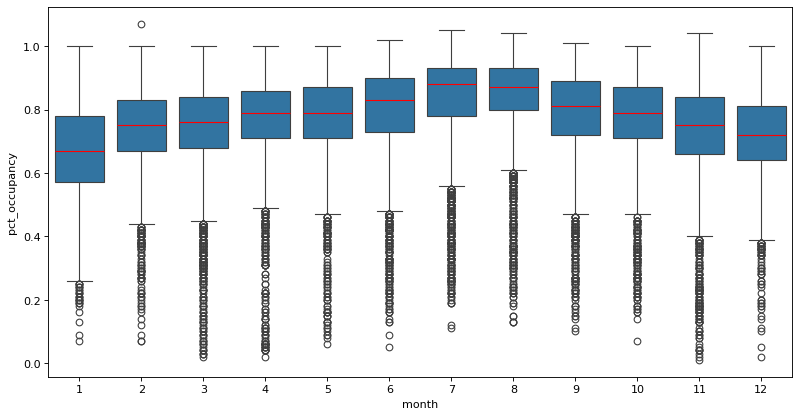

In [44]:
from matplotlib.pyplot import figure

figure(figsize=(12, 6), dpi=80)
_ = sns.boxplot(data=merged_df, y="pct_occupancy", x="month", medianprops={"color": "r", "linewidth": 1})

<Figure size 960x480 with 0 Axes>

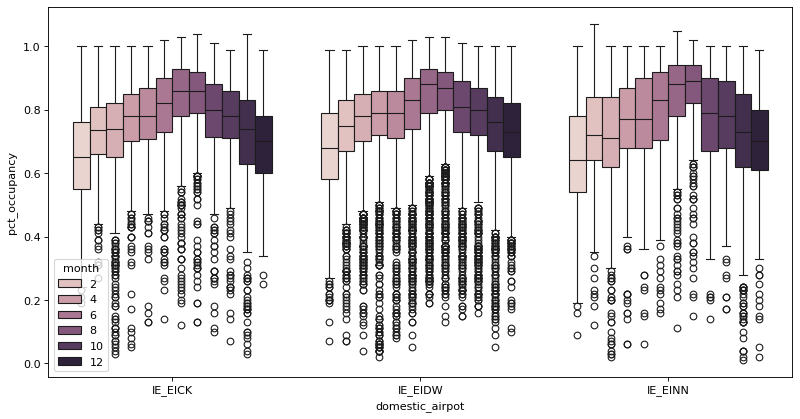

In [45]:

figure(figsize=(12, 6), dpi=80);
_ = sns.boxplot(data=merged_df, y="pct_occupancy", x="domestic_airpot", hue='month')

## Preprocessing

In [46]:
import matplotlib.image as mpimg
from sklearn.impute import SimpleImputer

In [47]:
merged_df_processed = merged_df

merged_df_processed.head()
merged_df_processed.columns

,year,month,direction,domestic_airpot,international_airport,country_code,num_passangers,total_capacity,num_flights,pct_occupancy
0,2012,3,arrivals,IE_EICK,BE_EBBR,Belgium,271.0,522.0,3.0,0.52
1,2012,4,arrivals,IE_EICK,BE_EBBR,Belgium,1346.0,2262.0,13.0,0.60
2,2012,5,arrivals,IE_EICK,BE_EBBR,Belgium,1377.0,2262.0,13.0,0.61
3,2012,6,arrivals,IE_EICK,BE_EBBR,Belgium,1082.0,2262.0,13.0,0.48
4,2012,7,arrivals,IE_EICK,BE_EBBR,Belgium,1550.0,2262.0,13.0,0.69


Index(['year', 'month', 'direction', 'domestic_airpot',
       'international_airport', 'country_code', 'num_passangers',
       'total_capacity', 'num_flights', 'pct_occupancy'],
      dtype='object')

#### Imputing missing data

In [48]:
imputer = SimpleImputer(strategy='mean')
merged_df_processed['num_passangers'] = imputer.fit_transform(merged_df_processed['num_passangers'].values.reshape(-1, 1) )
merged_df_processed['total_capacity'] = imputer.fit_transform(merged_df_processed['total_capacity'].values.reshape(-1, 1) )
merged_df_processed['num_flights'] = imputer.fit_transform(merged_df_processed['num_flights'].values.reshape(-1, 1) )

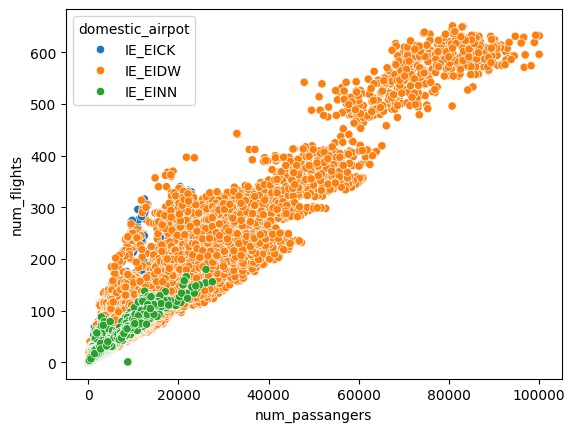

In [49]:
_ = sns.scatterplot(data=merged_df_processed, x="num_passangers", y="num_flights", hue="domestic_airpot")

#### Scaling

In [50]:
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    scale,
    minmax_scale,
)

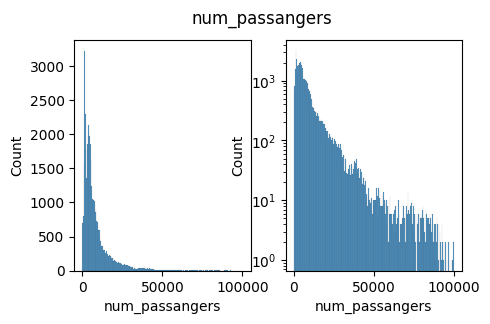

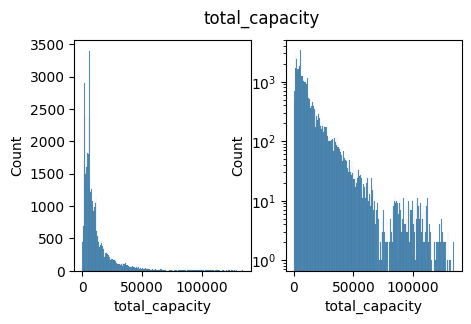

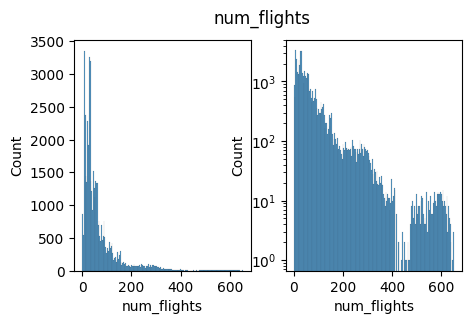

In [51]:
COLS_TO_SCALE = ['num_passangers', 'total_capacity', 'num_flights']

for col in COLS_TO_SCALE:
    f, sca = plt.subplots(1, 2, figsize=(5, 3))
    _ = sns.histplot(data=merged_df_processed, x=col, ax=sca[0])
    _ = sns.histplot(data=merged_df_processed, x=col, ax=sca[1])
    sca[1].set_yscale('log')
    #ax[1].set_xscale('log')
    _ = f.suptitle(col)



In [52]:
# Comparing different scaling methods
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

X_to_scale = merged_df_processed[COLS_TO_SCALE]

scaler_results = [
    ("Unscaled data", X_to_scale),
    ("Simple scaling", scale(X_to_scale)),
    ("Standard scaling", StandardScaler().fit_transform(X_to_scale)),
    ("Min-max scaling", MinMaxScaler().fit_transform(X_to_scale)),
    ("Max-abs scaling", MaxAbsScaler().fit_transform(X_to_scale)),
    ("Robust scaling", RobustScaler(quantile_range=(25, 75)).fit_transform(X_to_scale)),
    #("Power transformation (Yeo-Johnson)", PowerTransformer(method="yeo-johnson").fit_transform(X_to_scale)),
    ("Quantile transformation Uniform PDF", QuantileTransformer(output_distribution="uniform", random_state=42).fit_transform(X_to_scale)),
    ("Quantile transformation Gaussian PDF", QuantileTransformer(output_distribution="normal", random_state=42).fit_transform(X_to_scale)),
    ("Sample-wise L2 normalizing", Normalizer().fit_transform(X_to_scale)),
]

[None, None, None, None, None, None, None, None, None, None]

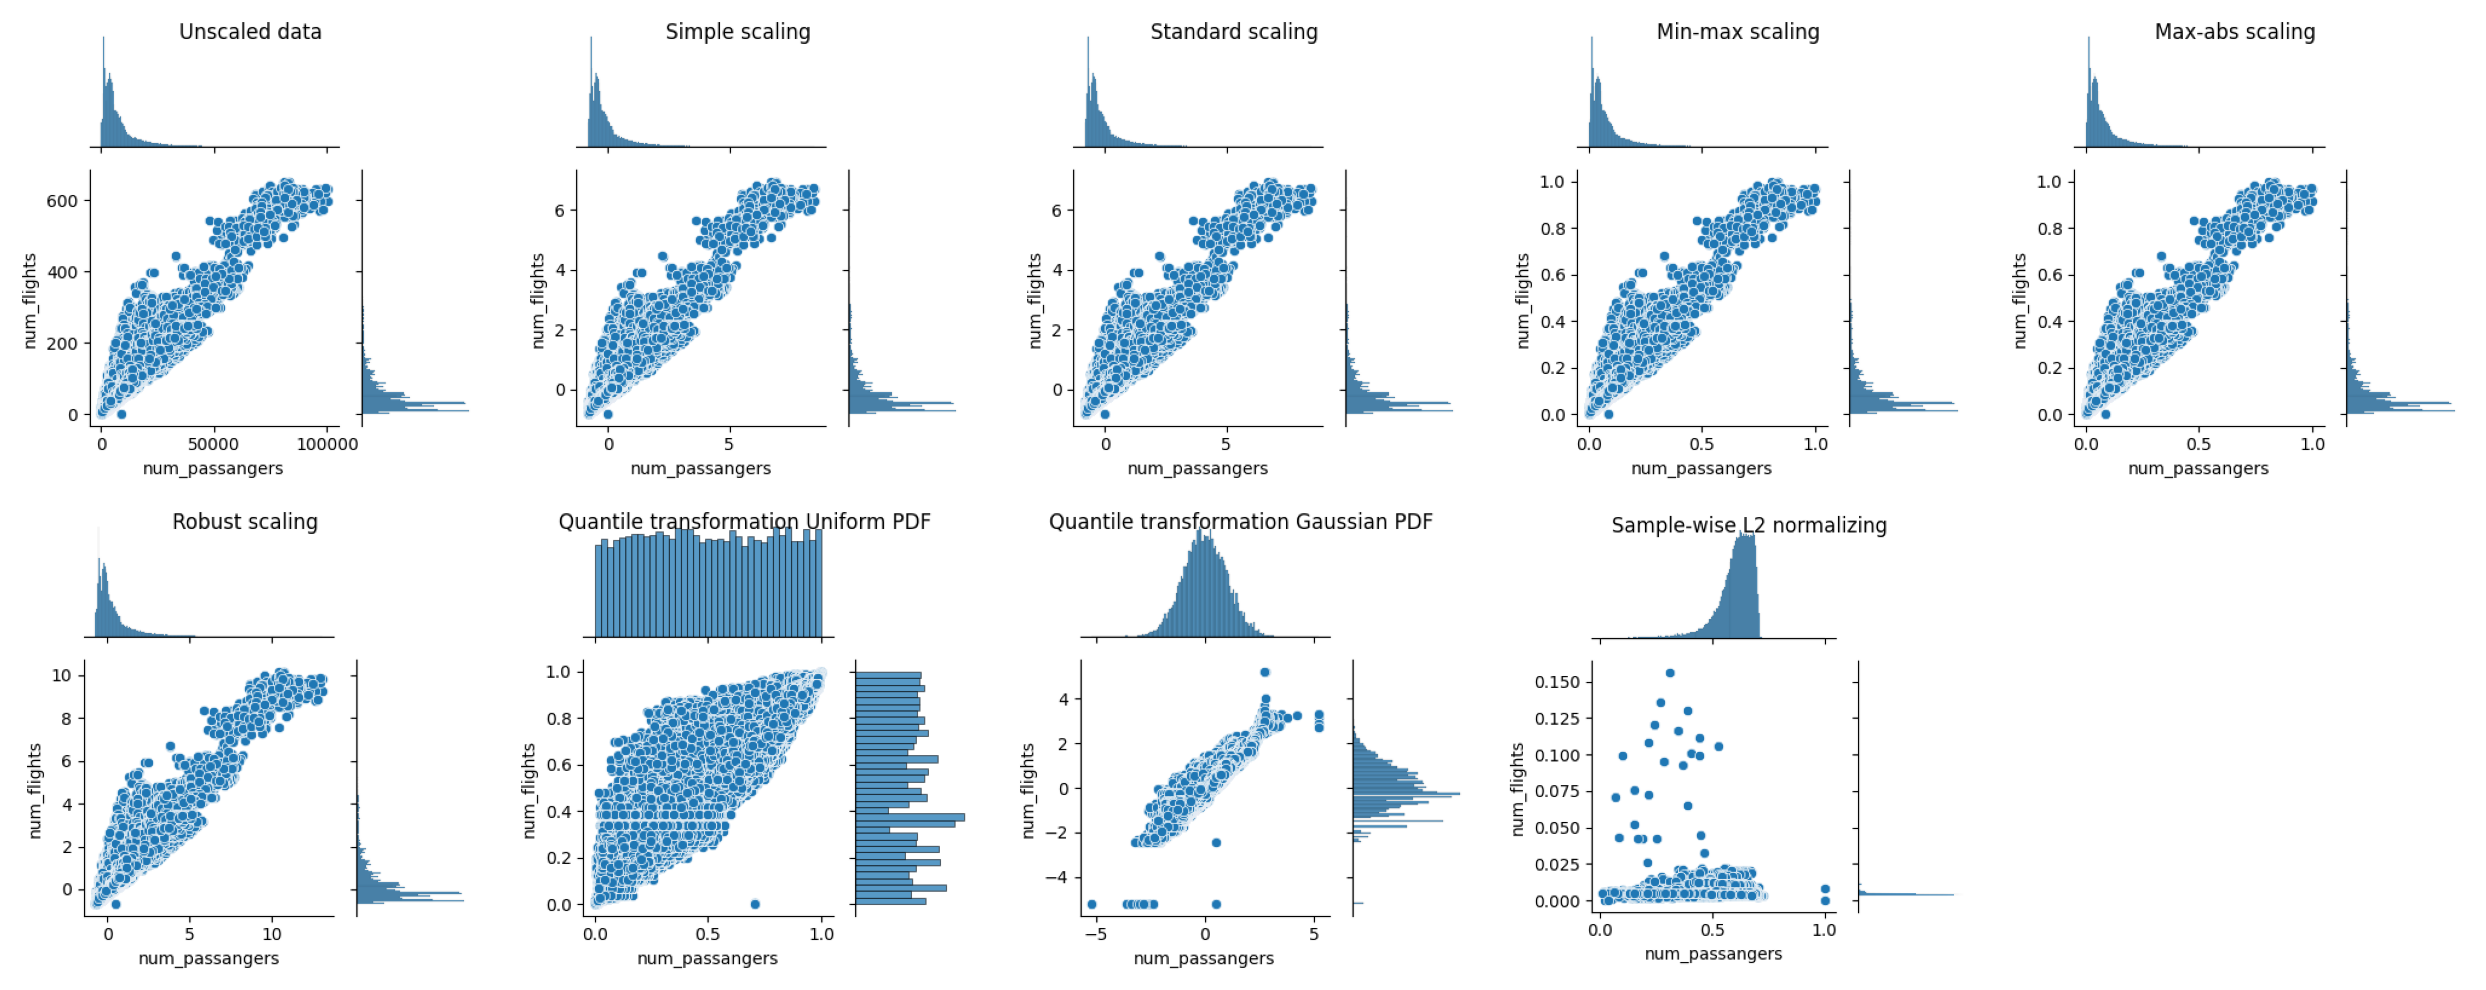

In [53]:
names = []
for i, res in enumerate(scaler_results):
    name = 'scaler-graphs/' + str(i) + '-' + res[0].lower().replace(' ', '-') + '.png'
    names.append(name)

for i, res in enumerate(scaler_results):
    df = pd.DataFrame(res[1], columns=COLS_TO_SCALE)
    j = sns.jointplot(data=df, x="num_passangers", y="num_flights", height=4, ratio=2);
    _ = j.figure.suptitle(res[0])
    j.savefig(name[i])
    plt.close(name[i])

# https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot - SOLUTION FROM HERE
f, axarr = plt.subplots(2, 5, figsize=(25, 10))

_ = axarr[0,0].imshow(mpimg.imread(names[0]))
_ = axarr[0,1].imshow(mpimg.imread(names[1]))
_ = axarr[0,2].imshow(mpimg.imread(names[2]))
_ = axarr[0,3].imshow(mpimg.imread(names[3]))
_ = axarr[0,4].imshow(mpimg.imread(names[4]))
_ = axarr[1,0].imshow(mpimg.imread(names[5]))
_ = axarr[1,1].imshow(mpimg.imread(names[6]))
_ = axarr[1,2].imshow(mpimg.imread(names[7]))
_ = axarr[1,3].imshow(mpimg.imread(names[8]))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.show()


## Machine Learning <a class="anchor" id="ml"></a>


### Split -> Encode -> Scale
Splitting data into dependent features and independednt variables

In [64]:
from sklearn.preprocessing import  OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

In [121]:
from imblearn.under_sampling import NearMiss

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings


In [110]:
# Spliting the dataset into independent and dependent variables

X_COLS = ['month', 
        'direction', 
        'international_airport',
        'num_passangers', 
        'total_capacity', 
        'num_flights']
X = merged_df_processed[X_COLS]

y = merged_df_processed['domestic_airpot']

X.head()
y.head()

,month,direction,international_airport,num_passangers,total_capacity,num_flights
0,3,arrivals,BE_EBBR,271.0,522.0,3.0
1,4,arrivals,BE_EBBR,1346.0,2262.0,13.0
2,5,arrivals,BE_EBBR,1377.0,2262.0,13.0
3,6,arrivals,BE_EBBR,1082.0,2262.0,13.0
4,7,arrivals,BE_EBBR,1550.0,2262.0,13.0


0    IE_EICK
1    IE_EICK
2    IE_EICK
3    IE_EICK
4    IE_EICK
Name: domestic_airpot, dtype: object

In [111]:
def split_encode_scale(X, y, scl):
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 82)

    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    _ = enc.fit(X_train)
    X_train = enc.transform(X_train)
    X_test = enc.transform(X_test)

    # Encode labels with LabelEncoder, since this one accept a one-dimentional array
    lenc = LabelEncoder()
    y_train = lenc.fit_transform(y_train)
    y_test = lenc.transform(y_test)

    # Apply chosen scaler
    X_train = scl.fit_transform(X_train)
    X_test = scl.transform(X_test)

    return X_train, X_test, y_train, y_test


In [58]:
X_train, X_test, y_train, y_test = split_encode_scale(X, y, MinMaxScaler())
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((47411, 6), (47411,), (37928, 6), (37928,), (9483, 6), (9483,))

In [124]:
def run_CFL(model, X_train, y_train, X_test, y_test, cols=X_COLS):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    print("*** Accuracy: ", metrics.accuracy_score(y_test, y_predict))
    print("*** Classification Report: \n", classification_report(y_test, y_predict))

    #pd.Series(model.feature_importances_, index=df.columns).nlargest(4).plot(kind='barh')

    cm = confusion_matrix(y_test, y_predict)    
    fig, ax = plt.subplots(figsize=(6,4), dpi=100)
    display = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    ax.set(title=f'Confusion Matrix for: {model}')
    display.plot(ax=ax);


def run_GridSearch(model, params, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(model, params, n_jobs=2, verbose = 4)
    grid.fit(X_train, y_train)

    grid.best_params_
    grid.best_estimator_
    y_predict = grid.predict(X_test)
    
    print("*** Best Params: ", grid.best_params_)
    print("*** Best Estimator: ", grid.best_estimator_)
    print("*** Best Score: ", grid.best_score_)

    pd.crosstab(y_test, y_predict, rownames = ['True'], colnames = ['Predicted'], margins = True)
    print(classification_report(y_test, y_predict))


In [125]:

svc_CFL = SVC()

run_CFL(svc_CFL, X_train, y_train, X_test, y_test)

### Iteration 2: Try Balancing the dataset
I am working with an imbalanbced dataset, where the number of observations for the Dublin airport is over triple the other airports. Try to resample.

In [63]:
nr = NearMiss()

X_train_resampled, y_train_resampled = nr.fit_resample(X_train, y_train)
X_train_resampled.shape
y_train_resampled.shape

(16830, 6)

(16830,)

Re-try Support Vector Classifier

*** Accuracy: *** 0.5071180006327112
*** Classification Report: ***               precision    recall  f1-score   support

           0       0.29      0.61      0.39      1933
           1       0.77      0.57      0.66      6085
           2       0.15      0.09      0.11      1465

    accuracy                           0.51      9483
   macro avg       0.40      0.43      0.39      9483
weighted avg       0.58      0.51      0.52      9483



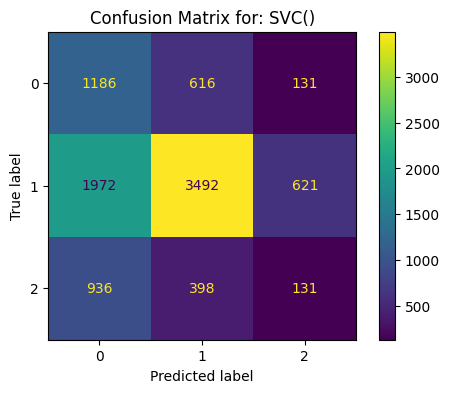

In [87]:
run_CFL(SVC(), X_train_resampled, y_train_resampled, X_test, y_test)

## Tree & Ensemble models

Decision Tree

*** Accuracy:  0.6800590530422862
*** Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.69      0.67      1933
           1       0.92      0.66      0.77      6085
           2       0.36      0.77      0.49      1465

    accuracy                           0.68      9483
   macro avg       0.65      0.70      0.64      9483
weighted avg       0.78      0.68      0.70      9483



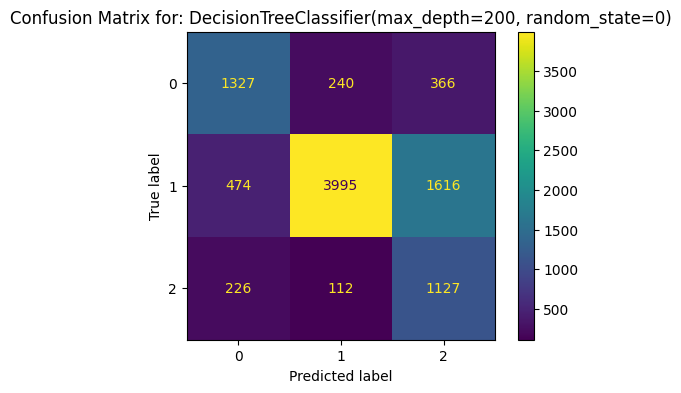

In [116]:
run_CFL(
    DecisionTreeClassifier(max_depth=200, random_state=0), 
    X_train_resampled, y_train_resampled, X_test, y_test
    )

Random Forest

*** Accuracy:  0.6263840556785827
*** Classification Report: 
               precision    recall  f1-score   support

           0       0.44      0.65      0.52      1933
           1       0.89      0.58      0.70      6085
           2       0.43      0.78      0.56      1465

    accuracy                           0.63      9483
   macro avg       0.59      0.67      0.60      9483
weighted avg       0.73      0.63      0.64      9483



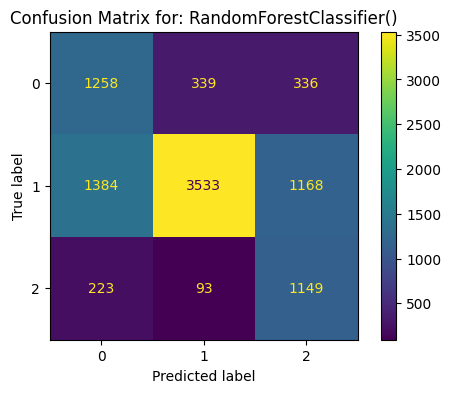

In [93]:

run_CFL(
    RandomForestClassifier(n_estimators=100), 
    X_train_resampled, y_train_resampled, X_test, y_test
    )

### Hyperparameter tuning
Random Forest Classifier seems to give the best results so far. I will thus, try and fine tune it and run cross validation grid search.


In [107]:
#### IMPORTANT ####
# Takes 59 mins to run - do not rerun, unless necessary
#### IMPORTANT ####

rand_forest_params = { 
    'n_estimators': list(range(100,851,150)), # [100, 250, 400, 550, 700, 850]
    'max_features': ['sqrt', 'log2'],
    'max_depth' : list(range(400,1201,400)), # [400, 800, 1200]
    'criterion' :['gini', 'entropy']
}

run_GridSearch(RandomForestClassifier(), rand_forest_params,
               X_train_resampled, y_train_resampled, X_test, y_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=100;, score=0.600 total time=   1.8s
[CV 2/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=100;, score=0.836 total time=   2.0s
[CV 3/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=100;, score=0.854 total time=   3.1s
[CV 4/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=100;, score=0.894 total time=   3.2s
[CV 5/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=100;, score=0.829 total time=   3.3s
[CV 1/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=250;, score=0.597 total time=   7.7s
[CV 2/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=250;, score=0.842 total time=   7.8s
[CV 3/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=250;, score=0.859 total time=   7.2s
[CV 4/5] END criterion=gini, max_d

Best Params: `{'criterion': 'gini', 'max_depth': 800, 'max_features': 'sqrt', 'n_estimators': 550}`

Best Estimator:  `RandomForestClassifier(max_depth=800, n_estimators=550)`

Best Score:  `0.8067142008318479`

              precision    recall  f1-score   support

           0       0.46      0.65      0.53      1933
           1       0.89      0.61      0.72      6085
           2       0.44      0.78      0.56      1465

    accuracy                           0.64      9483
   macro avg       0.59      0.68      0.61      9483
weighted avg       0.73      0.64      0.66      9483

### Try an alternative: gradient boosted tree
https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting
This estimator is much faster than GradientBoostingClassifier for big datasets (n_samples >= 10 000).
This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. 

Compare agaist rad forest https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_hist_grad_boosting_comparison.html#sphx-glr-auto-examples-ensemble-plot-forest-hist-grad-boosting-comparison-py

*** Accuracy:  0.7447010439734262
*** Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.67      0.66      1933
           1       0.94      0.75      0.83      6085
           2       0.47      0.84      0.60      1465

    accuracy                           0.74      9483
   macro avg       0.68      0.75      0.70      9483
weighted avg       0.80      0.74      0.76      9483



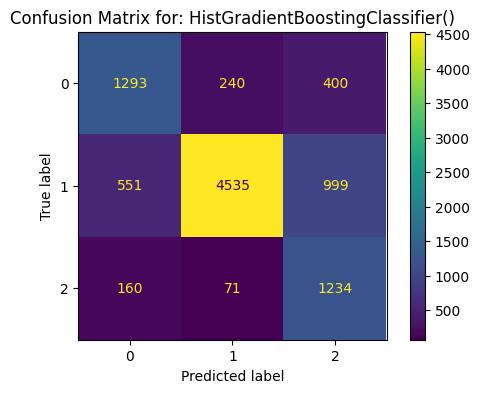

In [118]:

run_CFL(
    HistGradientBoostingClassifier(max_iter=100),
    X_train_resampled, y_train_resampled, X_test, y_test
)


In [ ]:
from sklearn.model_selection import KFold

models = {
    "Random Forest": RandomForestClassifier(
        min_samples_leaf=5, random_state=0
    ),
    "Hist Gradient Boosting": HistGradientBoostingClassifier(
        max_leaf_nodes=15, random_state=0, early_stopping=False
    ),
}
param_grids = {
    "Random Forest": {"n_estimators": [550], 'max_depth': [800], 'criterion': ['gini']},
    "Hist Gradient Boosting": {"max_iter": [10, 20, 50, 100, 300, 500]},
}
cv = KFold(n_splits=4, shuffle=True, random_state=0)

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=cv,
    ).fit(X_train_resampled, y_train_resampled)
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)